<a href="https://colab.research.google.com/github/BaranovTim/Pytorch_course/blob/main/pytorch_course_YT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch WorkFlow

In [ ]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks for network
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

Data (preparing and loading)

Data can be almost anything... in ML.
Excel, imgs, videos, audios, DNAs, text

ML is a game of two parts:
1. Get data into numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some known data using the linear regression formuls (y = ax + b)


In [ ]:
#known parameters
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in ML in general)

Let's create a training and test set with our data

In [ ]:
train_split = int(0.8 * len(X))
train_split

X_train, y_train = X[:train_split], y[:train_split] # training первых 80%
X_test, y_test = X[train_split:], y[train_split:] # training оставшихся

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=15, label='Testing data')

  # Are there predictions?
  if predictions is not None:
    # Plot them if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14});




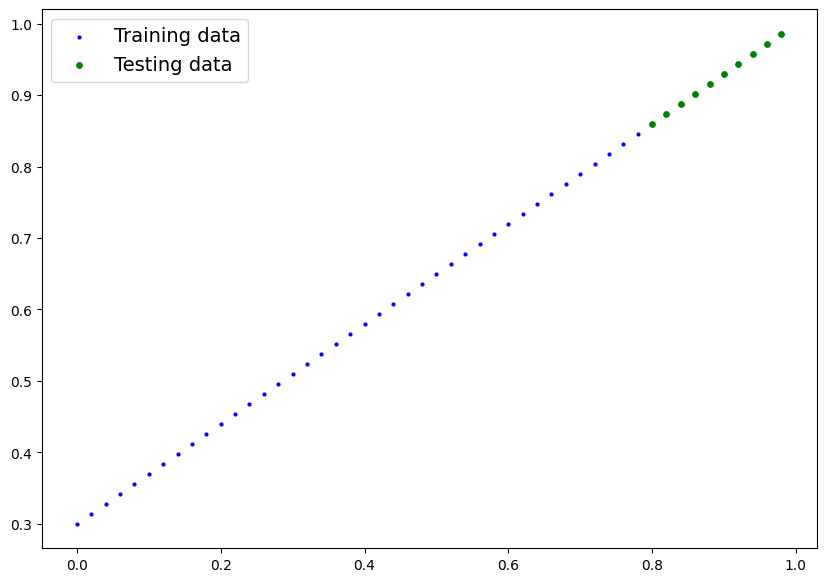

In [ ]:
plot_predictions()

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through:
1. Gradient descent
2. Backpropagation

In [ ]:
from torch import nn
# Building model
#create linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everything in Pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float))

    # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # 'x' is the input data
    return self.weights * x + self.bias


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation


In [ ]:
torch.rand(1)

tensor([0.7928])

### Checking the contents of our pytorch model

We have created a model, let's see what is inside..

We can check our model parameters or what is inside using .parameters()


In [ ]:
torch.manual_seed(42)

#instance of the model
model_0 = LinearRegressionModel()

#check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

### Making predictions using torch.inference_mode()

To check our model's predictive power, let's see how well it predicts 'y_test' based on 'X_test'

When we pass data through our model, it is going to run it through the forward() method.

In [ ]:
#Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

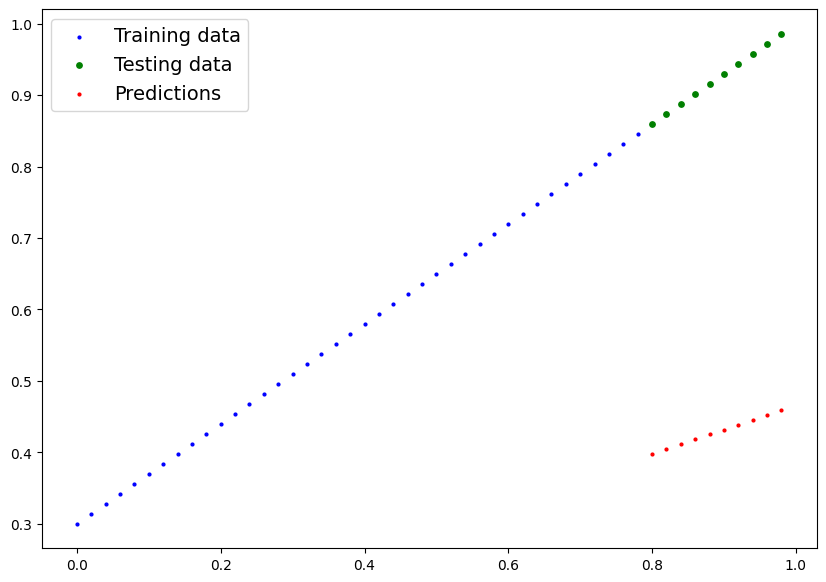

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some unknown parameters (these maybe random) to some known parameters

Or in other words from a por representation of the data to a better representation of the data

One way to measure how poor ur predictions are, is to use the loss function.

Loss functions may also be called cost functions or criterion in different areas. For our case, we're going to call it a loss function.

* *Loss function*: A function to measure how wrong ur model's predictions are to the ideal outputs, lower is better.

* *Optimizer*: Takes into account the loss of a model and adjust the models's parameters (e.g. weight and bias) to improve the loss function.

And specifically for Pytorch we need:

* A training loop
* A testing loop


In [ ]:
#loss func
loss_fn = nn.L1Loss()

#optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.001) # lr - learning rate(most important)

значение lr показывает меняет ли оно одну десятую или сотую, мб тысячную в наших прогнозах чтобы приблизиться к истинному значению



In [ ]:
loss_fn

L1Loss()

### Building a training loop (and testing loop)

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving through our model's forward() functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backwards - moe backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data.. (we have set it ourselves)
epochs = 50

#Loop through the data
for epoch in range(epochs):
  #Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()  #by default how the optimizer changes will accumulate through the loop so..
                    #we have to zero them above in step 3 for the next iteration of the loop

  # Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # turn off gradient tracking and a couple more things behind the scenes
    #Do the forward pass
    test_pred = model_0(X_test)

    #Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  #print out what is happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}')
    print(model_0.state_dict())


Loss: 0.000547530478797853
Epoch: 0 | Test: 0.000547530478797853 | Test loss: 0.0009484231704846025
OrderedDict([('weights', tensor([0.6993])), ('bias', tensor([0.2997]))])
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Epoch: 10 | Test: 0.000547530478797853 | Test loss: 0.0009484231704846025
OrderedDict([('weights', tensor([0.6993])), ('bias', tensor([0.2997]))])
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Loss: 0.0006045512855052948
Loss: 0.000547530478797853
Epoch: 20 | Test: 0.000547530478797853 | Test loss: 0.0009484231704846025
OrderedDict([('weights', tensor([0.6993])), ('bias', ten

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

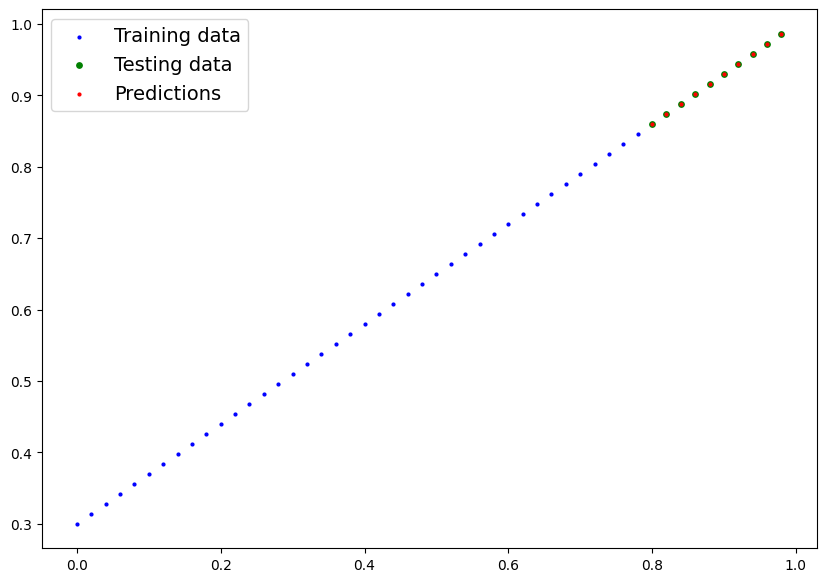

In [ ]:
plot_predictions(predictions=test_pred)

##Saving a model in PyTorch

There are 3 main mothods for saving and loading models in Pytorch

1. torch.save() - allows u to save an object in Python's pickle format
2. torch.load() - allows you to load a saved object
3. torch.nn.Module.load_state_dict() - this allows u to load models saved state dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])

In [ ]:
#saving our Pytoch model

from pathlib import Path

#1. create model directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#3. Save the model state dict

print(f'Saving model to:{MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to:models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 2320 Jan  3 01:44 01_pytorch_workflow_model_0.pth


## Loading a Pytorch model

Since we saved our model's 'state_dict()' rather the entire model, we'll create a new instance of our model class and load the saved 'state_dict()' into that.

In [ ]:
import torch
from torch import nn
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

#Load the saved state_dict of model_0 (this will update a new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-122-f20e6dce5488>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8604],
        [0.8744],
        [0.8884],
        [0.9024],
        [0.9164],
        [0.9304],
        [0.9444],
        [0.9584],
        [0.9724],
        [0.9864]])

In [ ]:
# Make some models preds

model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8604],
        [0.8744],
        [0.8884],
        [0.9024],
        [0.9164],
        [0.9304],
        [0.9444],
        [0.9584],
        [0.9724],
        [0.9864]])

In [ ]:
#Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go through the steps above and see it all in one place



Create device-agnostic code.
This means if we have got access to a GPU, our code will use it (for potentially faster computing)

If no GPU is available, the code will default to using CPU

Using device: cpu
Epoch: 0 | Test: 0.5551779866218567 | Test loss: 0.5739762187004089
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 10 | Test: 0.4399680495262146 | Test loss: 0.4392663538455963
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 20 | Test: 0.3247582018375397 | Test loss: 0.30455657839775085
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 30 | Test: 0.20954827964305878 | Test loss: 0.16984674334526062
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 40 | Test: 0.09433844685554504 | Test loss: 0.03513689711689949
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 50 | Test: 0.023886386305093765 | Test loss: 0.04784906655550003
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3007]))])
Epoch: 60 | Test: 0.0199567973613739 | Test loss: 0.04580312222242355
OrderedDict([('weights', tensor([0.6997])), ('bias', 

<ipython-input-137-873b4717316a>:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

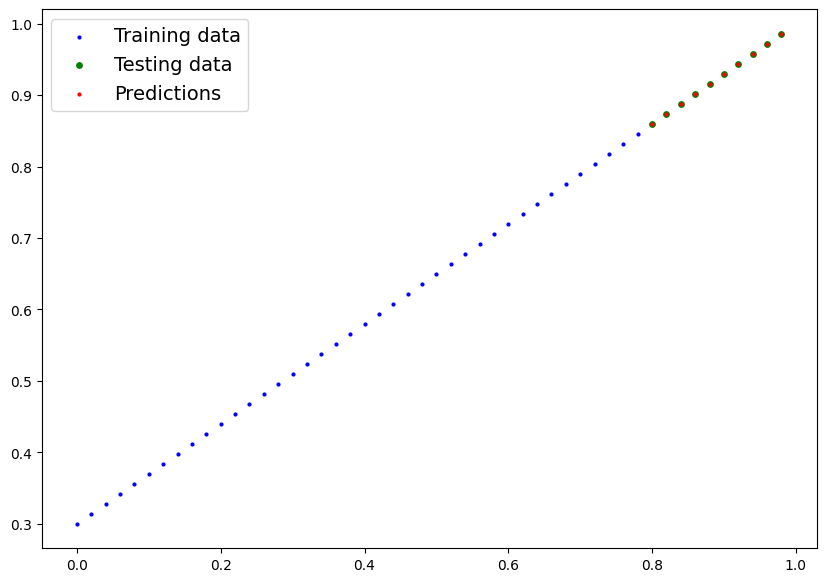

In [ ]:
# 1. Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path


#Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu' #'cuda' is nvidia's gpu
print(f'Using device: {device}')

#Create some data using the linear regression formula of y=ax+b

weight = 0.7
bias = 0.3

#Create range values
start = 0
end = 1
step = 0.02

#Create X and y
X = torch.arange(start,end,step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias

#split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

#plot the data

def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=15, label='Testing data')

  # Are there predictions?
  if predictions is not None:
    # Plot them if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14});


#Building a Linear model
#create it by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #Use nn.Linear() for creating model params
    self.linear_layer = nn.Linear(in_features=1, #одно значение x
                                  out_features=1) #к одному значению y

  def forward(self, x: torch.Tensor) -> torch.Tensor : # вот этот код означает что x должен быть torch.Tensor и функция должна вернуть также torch.Tensor
    return self.linear_layer(x)

#set the seed
torch.manual_seed(42)

#making a model
model_1 = LinearRegressionModelV2()

#set the model to use the target device
model_1.to(device)


#Training

#Setup the loss func
loss_func = nn.L1Loss() # same as MAE

#Setup the optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01)

#Training loop
epochs = 200

#Put data on a target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  #1. Forward pass
  y_pred = model_1(X_train)

  #2. Calculate the loss
  loss = loss_func(y_pred, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perforn backpropagation
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  # Testing

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

  test_loss = loss_func(test_pred, y_test)

  #Print out what is happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}')
    print(model_0.state_dict())

#Making and evaluating predictions

#Turn model into evaluation mode
model_1.eval()

#Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

#On graph
plot_predictions(predictions=y_preds.cpu())



#Saving and training a model

#1. create model directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#3. Save the model state dict

print(f'Saving model to:{MODEL_SAVE_PATH}')
torch.save(model_1.state_dict(), MODEL_SAVE_PATH)


#loading it

#To load in a saved state_dict we have to create a new instance of our model class
loaded_model_1 = LinearRegressionModelV2()

#Load the saved state_dict of model_1 (this will update a new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

#Put the loaded model to the device
loaded_model_1.to(device)


#Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds